## Directories, Libraries and Data|

In [1]:
import numpy as np
import pandas as pd
from prophet import Prophet

In [2]:
df = pd.read_csv("data/Udemy_wikipedia_visits.csv")

In [3]:
df.head()

,Date,Udemy,Easter,Christmas,Black Friday
0,1/1/2016,311,0,0,0
1,1/2/2016,564,0,0,0
2,1/3/2016,517,0,0,0
3,1/4/2016,652,0,0,0
4,1/5/2016,756,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          1827 non-null   object
 1   Udemy         1827 non-null   int64 
 2   Easter        1827 non-null   int64 
 3   Christmas     1827 non-null   int64 
 4   Black Friday  1827 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 71.5+ KB


In [5]:
df.describe()

,Udemy,Easter,Christmas,Black Friday
count,1827.000000,1827.000000,1827.000000,1827.000000
mean,943.068418,0.002737,0.002737,0.002737
std,531.341700,0.052256,0.052256,0.052256
min,209.000000,0.000000,0.000000,0.000000
25%,542.500000,0.000000,0.000000,0.000000
50%,832.000000,0.000000,0.000000,0.000000
75%,1175.000000,0.000000,0.000000,0.000000
max,2847.000000,1.000000,1.000000,1.000000


<Axes: >

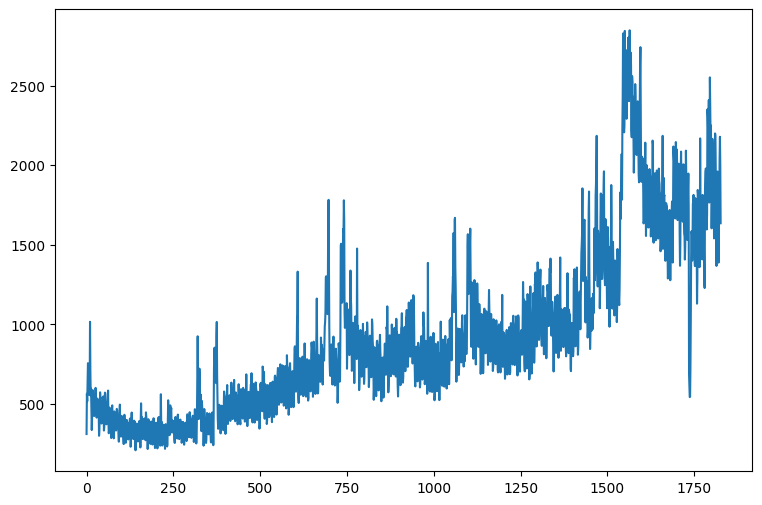

In [6]:
df.Udemy.plot(figsize = (9,6))

In [7]:
df.Date = pd.to_datetime(df.Date, format="%m/%d/%Y")

In [8]:
df.Date

0      2016-01-01
1      2016-01-02
2      2016-01-03
3      2016-01-04
4      2016-01-05
          ...    
1822   2020-12-27
1823   2020-12-28
1824   2020-12-29
1825   2020-12-30
1826   2020-12-31
Name: Date, Length: 1827, dtype: datetime64[ns]

In [9]:
df= df.rename(columns= {
    'Date': 'ds',
    'Udemy': 'y'
})

In [10]:
df.head()

,ds,y,Easter,Christmas,Black Friday
0,2016-01-01,311,0,0,0
1,2016-01-02,564,0,0,0
2,2016-01-03,517,0,0,0
3,2016-01-04,652,0,0,0
4,2016-01-05,756,0,0,0


In [11]:
easter_holidays = df[df.Easter == 1].ds

In [12]:
easter_holidays

86     2016-03-27
471    2017-04-16
821    2018-04-01
1206   2019-04-21
1563   2020-04-12
Name: ds, dtype: datetime64[ns]

In [13]:
easter = pd.DataFrame({
    'holiday': 'easter',
    'ds': easter_holidays,
    'lower_window': -5,
    'upper_window': 2
})

In [14]:
easter

,holiday,ds,lower_window,upper_window
86,easter,2016-03-27,-5,2
471,easter,2017-04-16,-5,2
821,easter,2018-04-01,-5,2
1206,easter,2019-04-21,-5,2
1563,easter,2020-04-12,-5,2


In [15]:
bf_dates = df[df["Black Friday"] == 1].ds
bf = pd.DataFrame({
    'holiday': 'black friday',
    'ds': bf_dates,
    'lower_window': -7,
    'upper_window': 5
})

In [16]:
holidays = pd.concat([easter, bf])

In [17]:
holidays

,holiday,ds,lower_window,upper_window
86,easter,2016-03-27,-5,2
471,easter,2017-04-16,-5,2
821,easter,2018-04-01,-5,2
1206,easter,2019-04-21,-5,2
1563,easter,2020-04-12,-5,2
329,black friday,2016-11-25,-7,5
693,black friday,2017-11-24,-7,5
1057,black friday,2018-11-23,-7,5
1428,black friday,2019-11-29,-7,5
1792,black friday,2020-11-27,-7,5


In [18]:
df = df.drop(columns=['Easter','Black Friday'])

In [19]:
df.head()

,ds,y,Christmas
0,2016-01-01,311,0
1,2016-01-02,564,0
2,2016-01-03,517,0
3,2016-01-04,652,0
4,2016-01-05,756,0


## Model

In [20]:
test_days = 31

training = df.iloc[:-test_days, : ]
test = df.iloc[-test_days: , : ]

In [21]:
training.tail(1)

,ds,y,Christmas
1795,2020-11-30,2551,0


In [22]:
test.head(1)

,ds,y,Christmas
1796,2020-12-01,2393,0


In [23]:
m = Prophet(
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    holidays = holidays,
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.05
)

m.add_regressor('Christmas',mode='multiplicative')
m.fit(training)

02:31:21 - cmdstanpy - INFO - Chain [1] start processing
02:31:21 - cmdstanpy - INFO - Chain [1] done processing


In [24]:
# Regressor coefficient

from prophet.utilities import regressor_coefficients
regressor_coefficients(m)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,Christmas,multiplicative,0.0,-0.324999,-0.324999,-0.324999


In [25]:
# Forecast

future = m.make_future_dataframe(periods = test_days, freq = 'D')

future = pd.concat([future, df.iloc[:,2:]],axis=1)

future

,ds,Christmas
0,2016-01-01,0
1,2016-01-02,0
2,2016-01-03,0
3,2016-01-04,0
4,2016-01-05,0
...,...,...
1822,2020-12-27,0
1823,2020-12-28,0
1824,2020-12-29,0
1825,2020-12-30,0


In [26]:
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas,Christmas_lower,Christmas_upper,additive_terms,...,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
0,2016-01-01,308.976369,183.170348,683.370776,308.976369,308.976369,0.0,0.0,0.0,123.586866,...,0.0,0.0,0.0,-22.264241,-22.264241,-22.264241,145.851107,145.851107,145.851107,432.563235
1,2016-01-02,309.315141,42.343729,556.556208,309.315141,309.315141,0.0,0.0,0.0,-11.141359,...,0.0,0.0,0.0,-180.805727,-180.805727,-180.805727,169.664368,169.664368,169.664368,298.173782
2,2016-01-03,309.653914,120.310093,600.026637,309.653914,309.653914,0.0,0.0,0.0,51.592700,...,0.0,0.0,0.0,-140.666865,-140.666865,-140.666865,192.259566,192.259566,192.259566,361.246614
3,2016-01-04,309.992686,350.643156,845.680594,309.992686,309.992686,0.0,0.0,0.0,288.857903,...,0.0,0.0,0.0,75.578074,75.578074,75.578074,213.279828,213.279828,213.279828,598.850589
4,2016-01-05,310.331459,418.313130,902.367209,310.331459,310.331459,0.0,0.0,0.0,334.676075,...,0.0,0.0,0.0,102.280183,102.280183,102.280183,232.395892,232.395892,232.395892,645.007534


In [27]:
print(forecast.columns)

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'Christmas', 'Christmas_lower', 'Christmas_upper', 'additive_terms',
       'additive_terms_lower', 'additive_terms_upper', 'black friday',
       'black friday_lower', 'black friday_upper', 'easter', 'easter_lower',
       'easter_upper', 'extra_regressors_multiplicative',
       'extra_regressors_multiplicative_lower',
       'extra_regressors_multiplicative_upper', 'holidays', 'holidays_lower',
       'holidays_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'weekly', 'weekly_lower', 'weekly_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'yhat'],
      dtype='object')


In [28]:
holiday = 'easter'
forecast[forecast[holiday].abs() > 0][['ds', holiday]]

,ds,easter
81,2016-03-22,-18.993106
82,2016-03-23,-35.736113
83,2016-03-24,4.146769
84,2016-03-25,30.012789
85,2016-03-26,73.832105
86,2016-03-27,85.305515
87,2016-03-28,85.029641
88,2016-03-29,27.751958
466,2017-04-11,-18.993106
467,2017-04-12,-35.736113


In [29]:
#Accuracy Assessment

predictions = forecast.yhat[-test_days:]
predictions

1796    2490.127854
1797    2356.376761
1798    2067.885738
1799    1967.499725
1800    1801.767594
1801    1834.238339
1802    2042.601903
1803    2061.490733
1804    2045.986196
1805    2016.613805
1806    1916.858436
1807    1753.716725
1808    1790.767249
1809    2005.684819
1810    2033.041024
1811    2027.810711
1812    2010.368408
1813    1924.005821
1814    1775.487601
1815    1828.125909
1816    2059.300007
1817    2103.262930
1818    2114.654761
1819    2113.506377
1820    1369.453601
1821    1908.855928
1822    1974.768689
1823    2217.580488
1824    2271.271967
1825    2290.246741
1826    2294.341020
Name: yhat, dtype: float64

In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [31]:
mean_absolute_error(test.y, predictions)

184.5327309354843

In [32]:
np.sqrt(mean_squared_error(test.y, predictions))

236.18722269520234

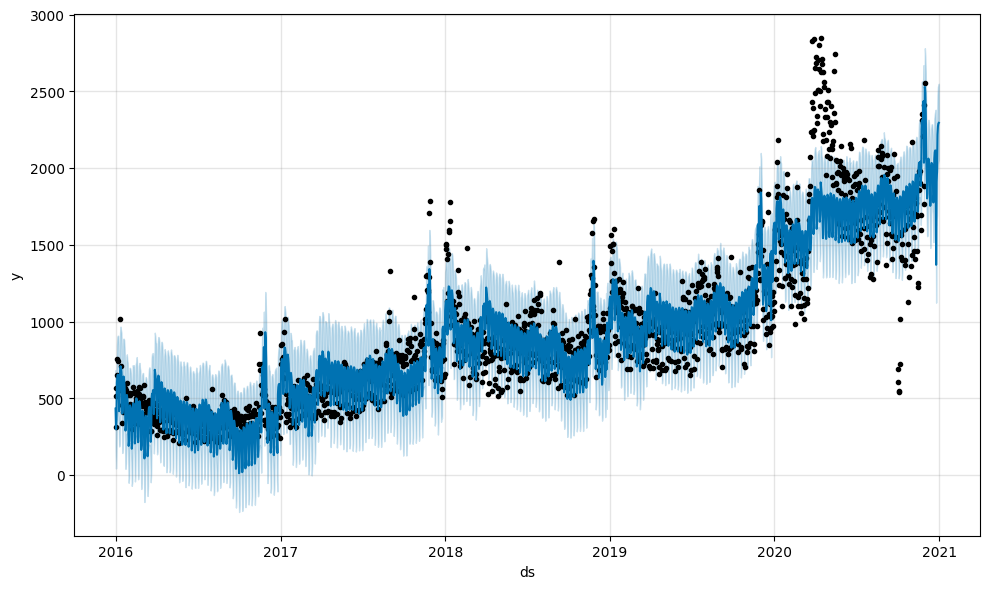

In [33]:
m.plot(forecast);

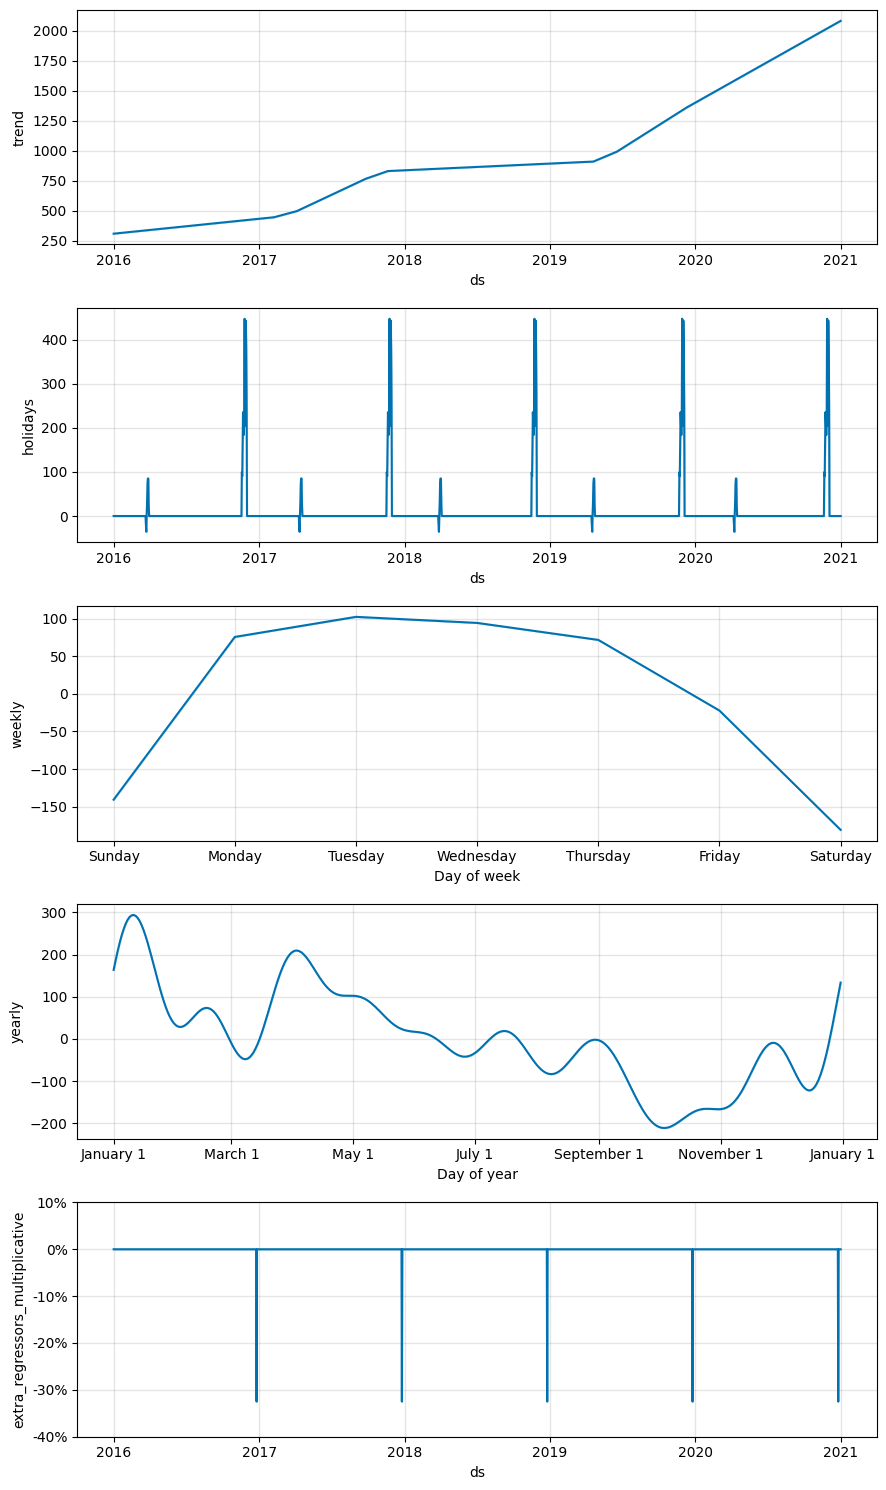

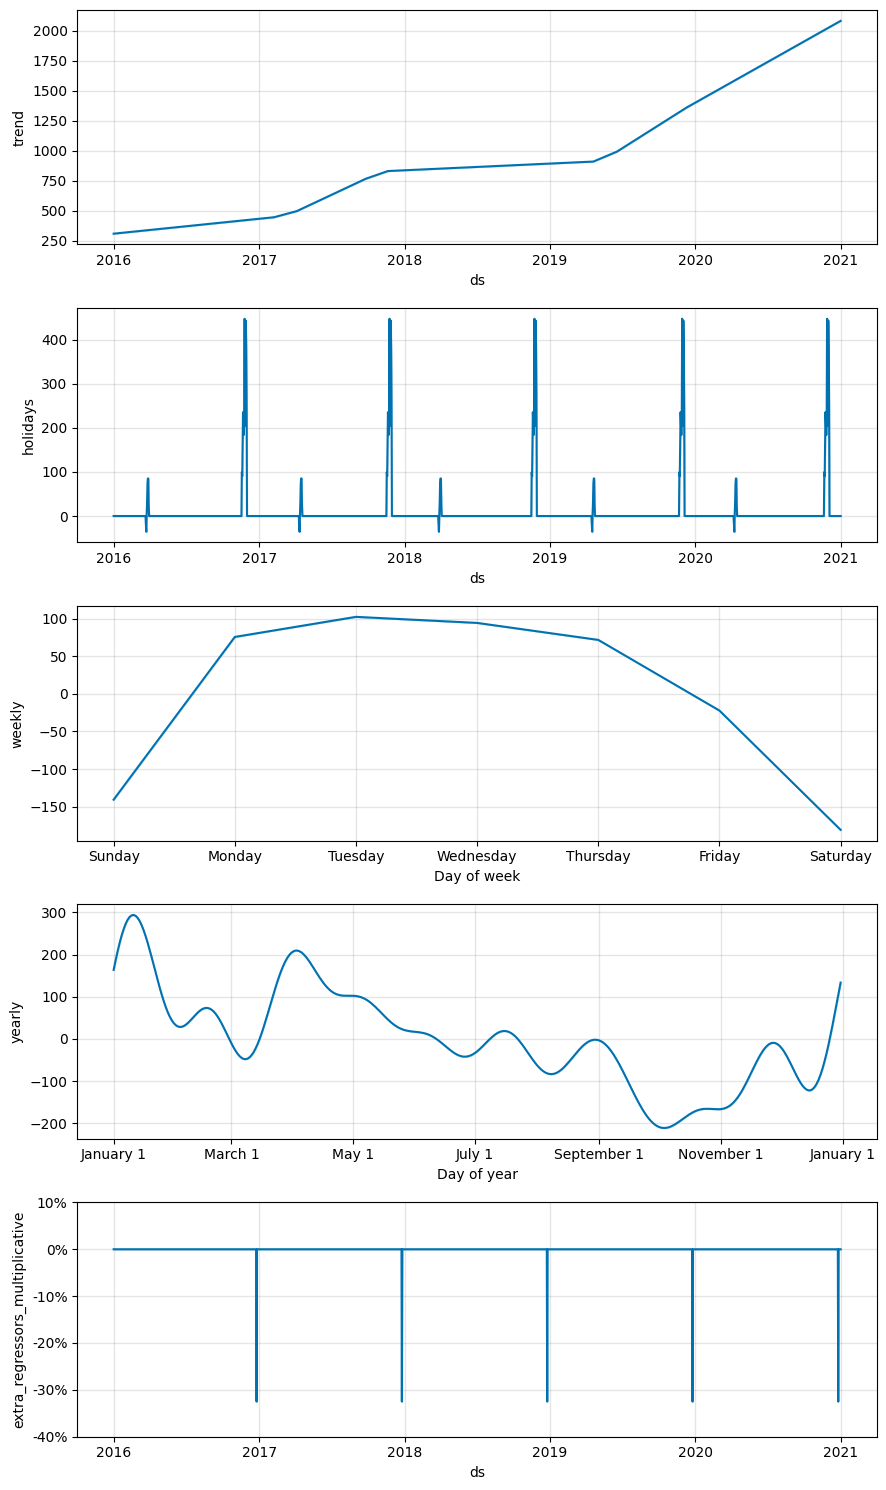

In [34]:
m.plot_components(forecast)

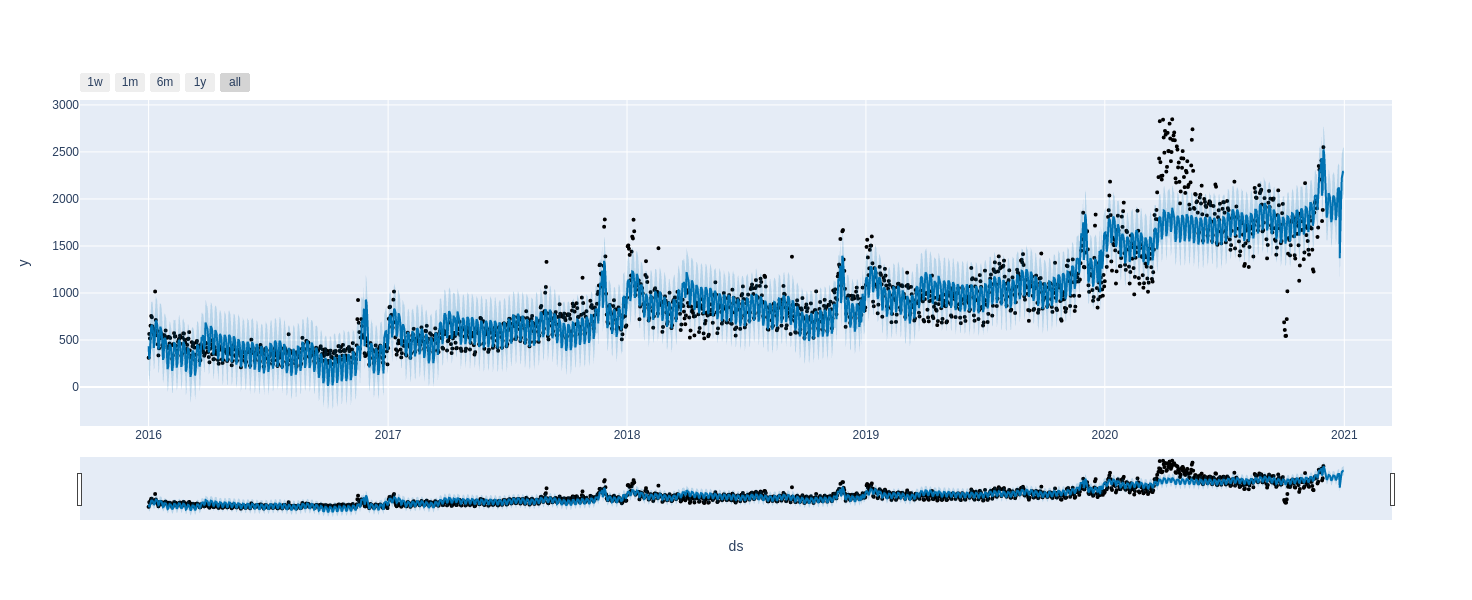

In [37]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m,forecast)

In [39]:
# plot_components_plotly(m,forecast)

In [40]:
# cross validation

from prophet.diagnostics import cross_validation
df_cv = cross_validation(m,horizon='31 days', initial='1450 days', parallel = 'processes')

df_cv.head()

02:39:47 - cmdstanpy - INFO - Chain [1] start processing
02:39:47 - cmdstanpy - INFO - Chain [1] start processing
02:39:47 - cmdstanpy - INFO - Chain [1] start processing
02:39:47 - cmdstanpy - INFO - Chain [1] start processing
02:39:47 - cmdstanpy - INFO - Chain [1] start processing
02:39:47 - cmdstanpy - INFO - Chain [1] start processing
02:39:47 - cmdstanpy - INFO - Chain [1] start processing
02:39:47 - cmdstanpy - INFO - Chain [1] start processing
02:39:47 - cmdstanpy - INFO - Chain [1] start processing
02:39:47 - cmdstanpy - INFO - Chain [1] start processing
02:39:47 - cmdstanpy - INFO - Chain [1] start processing
02:39:48 - cmdstanpy - INFO - Chain [1] start processing
02:39:48 - cmdstanpy - INFO - Chain [1] start processing
02:39:48 - cmdstanpy - INFO - Chain [1] start processing
02:39:48 - cmdstanpy - INFO - Chain [1] start processing
02:39:48 - cmdstanpy - INFO - Chain [1] start processing
02:39:50 - cmdstanpy - INFO - Chain [1] done processing
02:39:50 - cmdstanpy - INFO - Ch

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-12-26,1283.904639,1145.494148,1422.809515,1165,2019-12-25
1,2019-12-27,1225.347896,1107.443024,1352.883042,1111,2019-12-25
2,2019-12-28,1104.061400,967.409608,1233.333017,1038,2019-12-25
3,2019-12-29,1165.969900,1030.844032,1303.217145,971,2019-12-25
4,2019-12-30,1374.564180,1240.199298,1508.253344,1192,2019-12-25


In [41]:
mean_absolute_error(df_cv.y, df_cv.yhat)

397.58625790524655

In [43]:
np.sqrt(mean_squared_error(df_cv.y, df_cv.yhat))

515.3769002846452

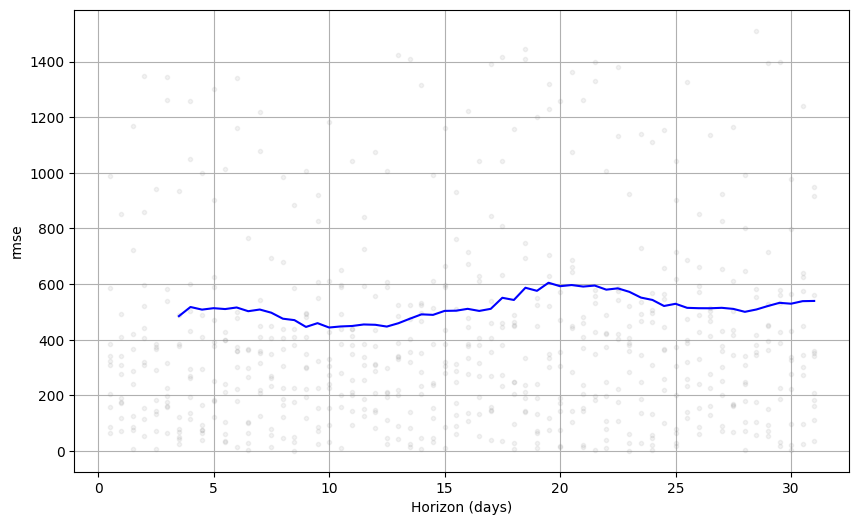

In [45]:
from prophet.plot import plot_cross_validation_metric

plot_cross_validation_metric(df_cv, metric='rmse');